In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import datetime

import sys
from os.path import dirname, abspath
import os
sys.path.append(dirname(dirname(abspath('__file__')))+'/utils')

from sklearn.model_selection import train_test_split

from keras.layers import Dense, LeakyReLU, Input, Dropout, Activation
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from keras import optimizers
import keras
import tensorflow as tf
import pickle

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

from check_performance import checkPerformance
from line_suppression import seg_line_sup

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
def NaiveApproach(data_sample):

    out = []
    sign = []
    indices = range(data_sample.shape[0])
    
    # 3 samples, mean    
    for i in range(4,data_sample.shape[0]-4):
        yn = data_sample
        ma = np.mean([yn[i-3], yn[i-2], yn[i-1]]) 
        mb = np.mean([yn[i+1], yn[i+2], yn[i+3]]) 
        thres = np.mean([(ma), (mb)]) + 0.75*18.1
        thres2 = np.mean([(ma), (mb)]) - 0.75*18.1
        o = (yn[i] > thres or  yn[i] < thres2 )
        out.append(o)
        if o and i in indices:
            if yn[i] >= thres:
                s = 1
            else:
                s = -1
            sign.append(s)
    
    results_tmp = np.where(out)[0] + 4
    results_naive = []
    for j in list(results_tmp):
        if j in indices:
            results_naive.append(j)
    
    return (results_naive, sign)

def correct_ts(data_sample):
    new_data_sample = data_sample.copy()
    result_idxs, signs = NaiveApproach(data_sample)
    res = zip(result_idxs, signs)
    for idx, sign in res:
        new_data_sample[idx] += -1 * sign * 18.1 
    return new_data_sample

In [5]:
## Input the filenames and parameters:
filename = 'segmented_ts_sim_with_UE_02.pkl'
original_indices = 'orig_x.npy'
full_indices = 'full_time_index.npy'
interpolation_method = 'original'

In [6]:
## Create variables with directories to external files:
directory = os.path.join(dirname(os.getcwd()), 'data_files/')
file_data = os.path.join(directory, filename)
file_full_indices = os.path.join(directory, full_indices)
file_orig_indices = os.path.join(directory, original_indices)

In [101]:
## Import the measurements:
data_imported = pd.read_pickle(file_data)
data_df = data_imported['time-series with UE']

## Correct the unwrapping errors
# data_df_corrected = data_df.map(correct_ts)
with open("data_df_corrected.pkl", "rb") as file:
    data_df_corrected = pickle.load(file)

## Load and calculate x-axis index:
orig_x = np.load(file_orig_indices)
full_x = np.load(file_orig_indices) 
indices = [int(i*365.25/11) for i in orig_x]

## Reverse indices using the last existing index
indices_reverse = []
for i in range(297):
    if i in indices:
        indices_reverse.append(i)
    else:
        indices_reverse.append(indices_reverse[i-1])

## Load the answers (ground truth):
points = pd.DataFrame(data_imported['list of UE'], index = data_imported.index)
points.columns = ['points']
segm_lines = pd.DataFrame(data_imported['segm_lines'], index = data_imported.index)
segm_lines.columns = ['segm_lines']

In [8]:
record_num = len(data_df)
record_length = len(data_df.iloc[0])

## Reshape the data from DataFrame into an array
data = np.zeros((record_num, record_length))
for idx, ar in enumerate(data_df_corrected.values):
    data[idx, :] = ar

In [9]:
ans_pt = np.zeros((record_num, record_length))
for idx, l in enumerate(points.values):
    for p in l[0]:
        ans_pt[idx, p] = 1

In [10]:
ans_seg = np.zeros((record_num, record_length))
for idx, l in enumerate(segm_lines.values):
    for s in l[0]:
        ans_seg[idx, s] = 1

In [11]:
test_ratio = 0.1
val_ratio = 0.2
val_ratio_adj = 0.2222222 #(val_ratio / (1 - test_ratio))

X_train, X_test, y_train, y_test = train_test_split(data, ans_seg, test_size=test_ratio, random_state=133)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio_adj, random_state=133)

print("Data split shape check:")
print(f"X_train shape: {X_train.shape} - {round(1 - test_ratio - val_ratio)*100}%")
print(f"y_train shape: {y_train.shape} - {round(1 - test_ratio - val_ratio)*100}%")
print(f"X_val shape: {X_val.shape} - {int(val_ratio*100)}%")
print(f"y_val shape: {y_val.shape} - {int(val_ratio*100)}%")
print(f"X_test shape: {X_test.shape} - {int(test_ratio*100)}%")
print(f"y_test shape: {y_test.shape} - {int(test_ratio*100)}%")

Data split shape check:
X_train shape: (7000, 297) - 100%
y_train shape: (7000, 297) - 100%
X_val shape: (2000, 297) - 20%
y_val shape: (2000, 297) - 20%
X_test shape: (1000, 297) - 10%
y_test shape: (1000, 297) - 10%


In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
scaler_val = MinMaxScaler()

X_train_scaled = scaler_train.fit_transform(X_train.T).T
X_test_scaled = scaler_test.fit_transform(X_test.T).T
X_val_scaled = scaler_val.fit_transform(X_val.T).T

In [55]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{datetime.now().strftime('%Y%m%d-%H%M%S')}/")
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=40,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [15]:
loss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)
m_prec = tf.keras.metrics.Precision()
m_rec = tf.keras.metrics.Recall()

In [16]:
def my_loss(y_true, y_pred):
    w = 10000
    mask = yt * (w-1) + 1
    return loss(y_true, y_pred) * mask

In [78]:
model = Sequential()
model.add(Input(shape=(297,)))
model.add(Dense(1024))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(2048))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(4096))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(297, activation='sigmoid'))

adam = optimizers.Adam(lr = 0.0001)
model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])

In [79]:
model_train = model.fit(X_train_scaled, y_train, 
                        batch_size=32, 
                        validation_split=0.2, 
                        epochs=250, 
#                         class_weight=cw,
                        callbacks=[tensorboard_callback, early_stopping_monitor],
                       )

Epoch 1/250
175/175 [==============================] - 1s 5ms/step - loss: 0.1741 - accuracy: 0.0037 - val_loss: 0.0331 - val_accuracy: 0.0029
Epoch 2/250
175/175 [==============================] - 1s 5ms/step - loss: 0.0372 - accuracy: 0.0018 - val_loss: 0.0329 - val_accuracy: 0.0036
Epoch 3/250
175/175 [==============================] - 1s 5ms/step - loss: 0.0351 - accuracy: 0.0048 - val_loss: 0.0324 - val_accuracy: 0.0021
Epoch 4/250
175/175 [==============================] - 1s 5ms/step - loss: 0.0339 - accuracy: 0.0034 - val_loss: 0.0323 - val_accuracy: 0.0029
Epoch 5/250
175/175 [==============================] - 1s 5ms/step - loss: 0.0339 - accuracy: 0.0047 - val_loss: 0.0336 - val_accuracy: 0.0029
Epoch 6/250
175/175 [==============================] - 1s 5ms/step - loss: 0.0331 - accuracy: 0.0030 - val_loss: 0.0321 - val_accuracy: 7.1429e-04
Epoch 7/250
175/175 [==============================] - 1s 5ms/step - loss: 0.0324 - accuracy: 0.0042 - val_loss: 0.0321 - val_accuracy: 0.

In [162]:
# model = keras.models.load_model("fcnn_model_arbitrary_128_256_512_384_dp_0_3")
# model = keras.models.load_model("fcnn_model_arbitrary_256_512_1024_384_dp_0_0")
# model = keras.models.load_model("fcnn_model_arbitrary_256_512_1024_384_dp_0_3")
# model = keras.models.load_model("fcnn_model_arbitrary_512_1024_2048_512_dp_0_0")
# model = keras.models.load_model("fcnn_model_arbitrary_512_1024_2048_512_dp_0_3") # 4
model = keras.models.load_model("fcnn_model_arbitrary_512_1024_4096_512_dp_0_3")  # 9

In [84]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 512)               152576    
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
activation_32 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_28 (Dropout)         (None, 1024)              0         
_________________________________________________________________
activation_33 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 4096)             

In [163]:
pred = model.predict(X_val_scaled)

In [91]:
pred = model.predict(X_test_scaled)

In [164]:
thresh_list = [0.0001, 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5]
thresh_recalls = []
thresh_precisions = []
thresh_recalls_sup = []
thresh_precisions_sup = []

for thresh in thresh_list:

    pred_list = np.where(pred > thresh)[0]

    answers = [list(np.where(item > thresh)[0]) for item in pred]
    gt = [list(np.where(gt_item > 0)[0]) for gt_item in y_val]
#     gt = [list(np.where(gt_item > 0)[0]) for gt_item in y_test]
    answers_scores =  [[pred[k][i] for i in ans] for k, ans in enumerate(answers)]
    answers_sup = [seg_line_sup(ans, vals) for ans, vals in zip(answers, answers_scores)]

    recalls = []
    precisions = []
    TPall = []
    FPall = []
    FNall = []

    for l in range(pred.shape[0]):
        r, p, tp, fp, fn = checkPerformance(answers[l], gt[l], tolerance = 5)
        recalls.append(r)
        precisions.append(p)
        TPall.append(tp)
        FPall.append(fp)
        FNall.append(fn)
    
    thresh_recalls.append(sum(TPall)/(sum(TPall) + sum(FNall)))
    thresh_precisions.append(sum(TPall)/(sum(TPall) + sum(FPall)))

    recalls = []
    precisions = []
    TPall = []
    FPall = []
    FNall = []

    for l in range(pred.shape[0]):
        r, p, tp, fp, fn = checkPerformance(answers_sup[l], gt[l], tolerance = 5)
        recalls.append(r)
        precisions.append(p)
        TPall.append(tp)
        FPall.append(fp)
        FNall.append(fn)


    print("Scores with non-minimum suppression", f"thresh: {thresh}")
    print()
    rec = sum(TPall)/(sum(TPall) + sum(FNall))
    prec = sum(TPall)/(sum(TPall) + sum(FPall))
    print('recall:',rec)
    print('precision:',prec, '\n')
    print(f"F1-score: {(2* rec * prec)/(rec + prec)}")
    print('-------------------------------------')

    thresh_recalls_sup.append(rec)
    thresh_precisions_sup.append(prec)


Scores with non-minimum suppression thresh: 0.0001

recall: 0.9751344086021505
precision: 0.029582059123343527 

F1-score: 0.05742213779730104
-------------------------------------
Scores with non-minimum suppression thresh: 0.001

recall: 0.915994623655914
precision: 0.04858487203250873 

F1-score: 0.09227540450883488
-------------------------------------
Scores with non-minimum suppression thresh: 0.005

recall: 0.7745295698924731
precision: 0.07615554894769881 

F1-score: 0.13867581144902685
-------------------------------------
Scores with non-minimum suppression thresh: 0.01

recall: 0.6754032258064516
precision: 0.09777691297368293 

F1-score: 0.1708239493477245
-------------------------------------
Scores with non-minimum suppression thresh: 0.02

recall: 0.5631720430107527
precision: 0.13467255926074728 

F1-score: 0.21736592957655146
-------------------------------------
Scores with non-minimum suppression thresh: 0.03

recall: 0.489247311827957
precision: 0.1655486071631609 


In [82]:
# model.save("fcnn_model_arbitrary_1024_2048_4096_1024_dp_0_3")

INFO:tensorflow:Assets written to: fcnn_model_arbitrary_1024_2048_4096_1024_dp_0_3/assets


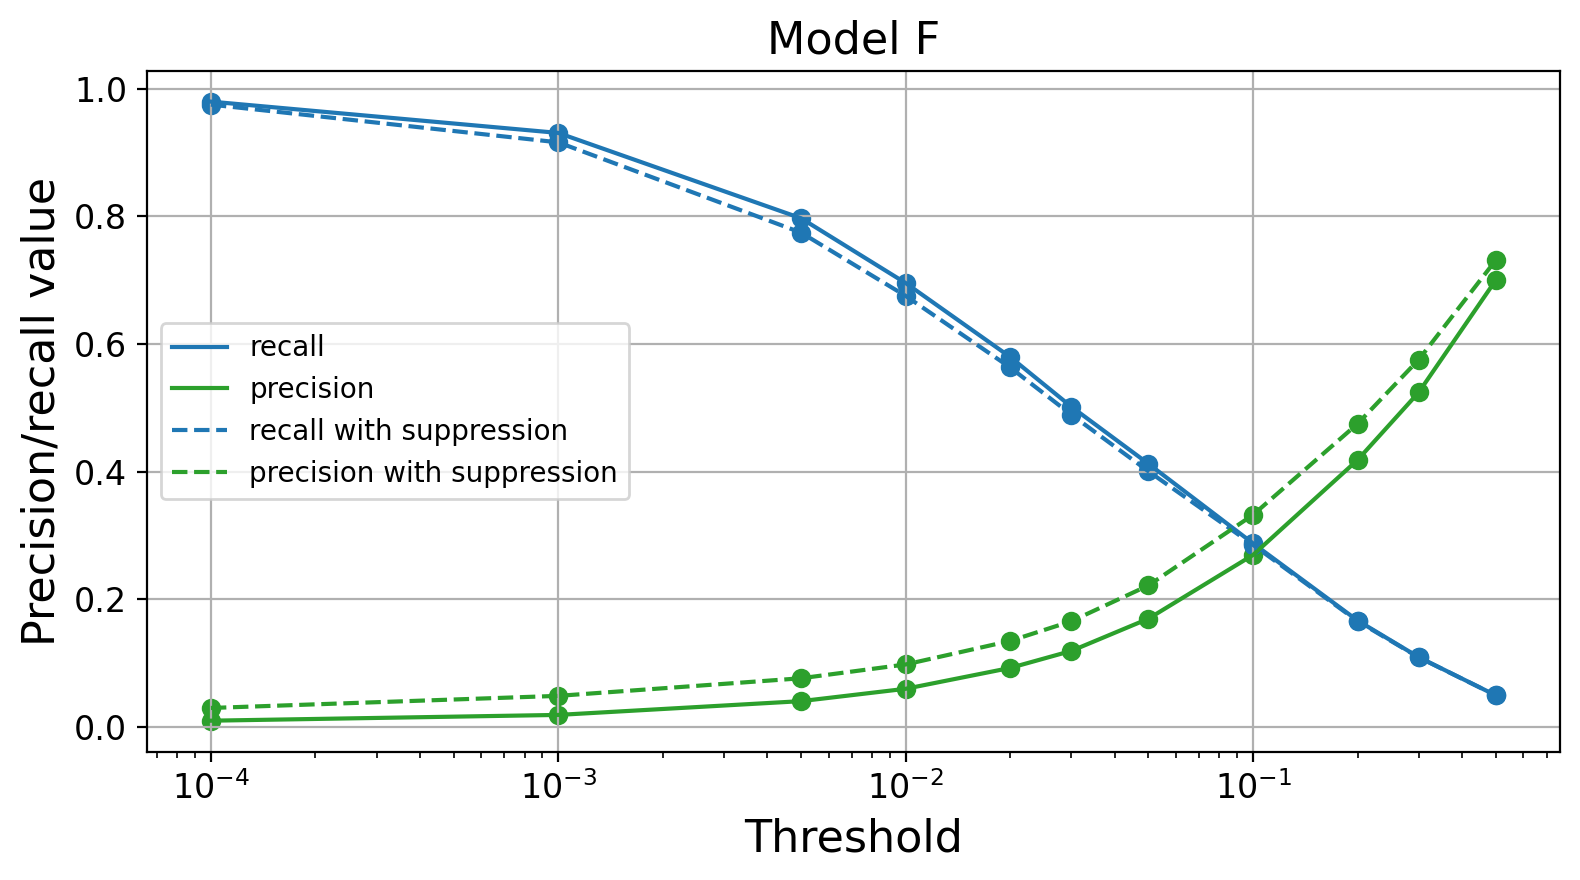

In [166]:
fig = plt.figure(figsize=(8,4.5), dpi=200)
ax = plt.gca()
rec, = plt.plot(thresh_list, thresh_recalls, color='tab:blue', label="recall")
plt.scatter(thresh_list, thresh_recalls, color='tab:blue')
prec, = plt.plot(thresh_list, thresh_precisions, color='tab:green', label="precision")
plt.scatter(thresh_list, thresh_precisions, color='tab:green')
plt.xscale('log')

rec_sup, = plt.plot(thresh_list, thresh_recalls_sup, color='tab:blue', linestyle="--", label="recall with suppression")
plt.scatter(thresh_list, thresh_recalls_sup, color='tab:blue')
prec_sup, = plt.plot(thresh_list, thresh_precisions_sup, color='tab:green', linestyle="--", label="precision with suppression")
plt.scatter(thresh_list, thresh_precisions_sup, color='tab:green')

plt.xlabel("Threshold", fontsize = 16)
plt.ylabel("Precision/recall value", fontsize = 16)
plt.title("Model F", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[rec, prec, rec_sup, prec_sup])

plt.grid()

fig.tight_layout()
# fig.savefig('scores_thresh_model_fcn_m9_F.jpg', bbox_inches="tight")
# fig.savefig('scores_model_C_w_title_big.jpg', bbox_inches="tight")

plt.show()

## Real data

In [126]:
with open("raw_real_input_data_ans_seg.pkl", "rb") as file:
    raw_real_input = pickle.load(file)
    
data_real = raw_real_input["data"]
ans_seg_real = raw_real_input["ans_seg"]

X_real = data_real
scaler_real = MinMaxScaler()
X_real_scaled = scaler_real.fit_transform(X_real.T).T


In [127]:
pred = model.predict(X_real_scaled)

thresh = 0.1

pred_list = np.where(pred > thresh)[0]
print(len(set(pred_list)))
print(pred_list)

answers = [list(np.where(item > thresh)[0]) for item in pred]
gt = [list(np.where(gt_item > 0)[0]) for gt_item in ans_seg_real]
answers_scores =  [[pred[k][i] for i in ans] for k, ans in enumerate(answers)]
answers_sup = [seg_line_sup(ans, vals) for ans, vals in zip(answers, answers_scores)]

recalls = []
precisions = []
TPall = []
FPall = []
FNall = []
    
for l in range(pred.shape[0]):
    r, p, tp, fp, fn = checkPerformance(answers[l], gt[l], tolerance = 5)
    recalls.append(r)
    precisions.append(p)
    TPall.append(tp)
    FPall.append(fp)
    FNall.append(fn)

print("Overall scores")
print()
print('recall:', np.nanmean(recalls))
print('precision:',np.nanmean(precisions), '\n')
print()
print('TPall: ', sum(TPall))
print('FPall: ', sum(FPall))
print('FNall: ', sum(FNall))
print()
print('recall:',sum(TPall)/(sum(TPall) + sum(FNall)))
print('precision:',sum(TPall)/(sum(TPall) + sum(FPall)), '\n')
print('-------------------------------------')

recalls = []
precisions = []
TPall = []
FPall = []
FNall = []
    
for l in range(pred.shape[0]):
    r, p, tp, fp, fn = checkPerformance(answers_sup[l], gt[l], tolerance = 5)
    recalls.append(r)
    precisions.append(p)
    TPall.append(tp)
    FPall.append(fp)
    FNall.append(fn)


print("Scores with non-minimum suppression")
print()
print('recall:', np.nanmean(recalls))
print('precision:',np.nanmean(precisions), '\n')
print()
print('TPall: ', sum(TPall))
print('FPall: ', sum(FPall))
print('FNall: ', sum(FNall))
print()
print('recall:',sum(TPall)/(sum(TPall) + sum(FNall)))
print('precision:',sum(TPall)/(sum(TPall) + sum(FPall)), '\n')
print('-------------------------------------')

print("Scores with non-minimum suppression", f"thresh: {thresh}")
print()
rec = sum(TPall)/(sum(TPall) + sum(FNall))
prec = sum(TPall)/(sum(TPall) + sum(FPall))
print('recall:',rec)
print('precision:',prec, '\n')
print(f"F1-score: {(2* rec * prec)/(rec + prec)}")
print('-------------------------------------')

59
[ 0  0  0  1  1  1  1  3  4  4  4  6  6  6  6  7  7  7  8  9  9  9 10 11
 11 11 11 12 12 12 12 13 13 14 14 15 15 15 16 16 16 18 19 20 20 20 20 21
 22 22 22 22 23 23 23 23 23 24 25 26 28 29 29 29 30 30 30 30 31 31 32 32
 32 32 34 35 35 37 38 38 39 39 39 40 42 42 42 45 46 48 48 48 48 49 51 52
 52 53 55 55 55 56 56 57 57 58 58 58 58 58 58 58 58 59 59 59 59 60 60 62
 62 65 65 67 67 69 70 71 71 71 71 71 71 73 74 74 74 74 74 74 75 80]
Overall scores

recall: 0.2582304526748971
precision: 0.2235875706214689 


TPall:  33
FPall:  109
FNall:  105

recall: 0.2391304347826087
precision: 0.2323943661971831 

-------------------------------------
Scores with non-minimum suppression

recall: 0.22736625514403289
precision: 0.2457627118644068 


TPall:  30
FPall:  89
FNall:  108

recall: 0.21739130434782608
precision: 0.25210084033613445 

-------------------------------------
Scores with non-minimum suppression thresh: 0.1

recall: 0.21739130434782608
precision: 0.25210084033613445 

F1-score: 0.2

In [128]:
real_range = sorted(list(set(indices_reverse)))

In [105]:
answers_sup[21]

[46, 53, 197, 269, 276]

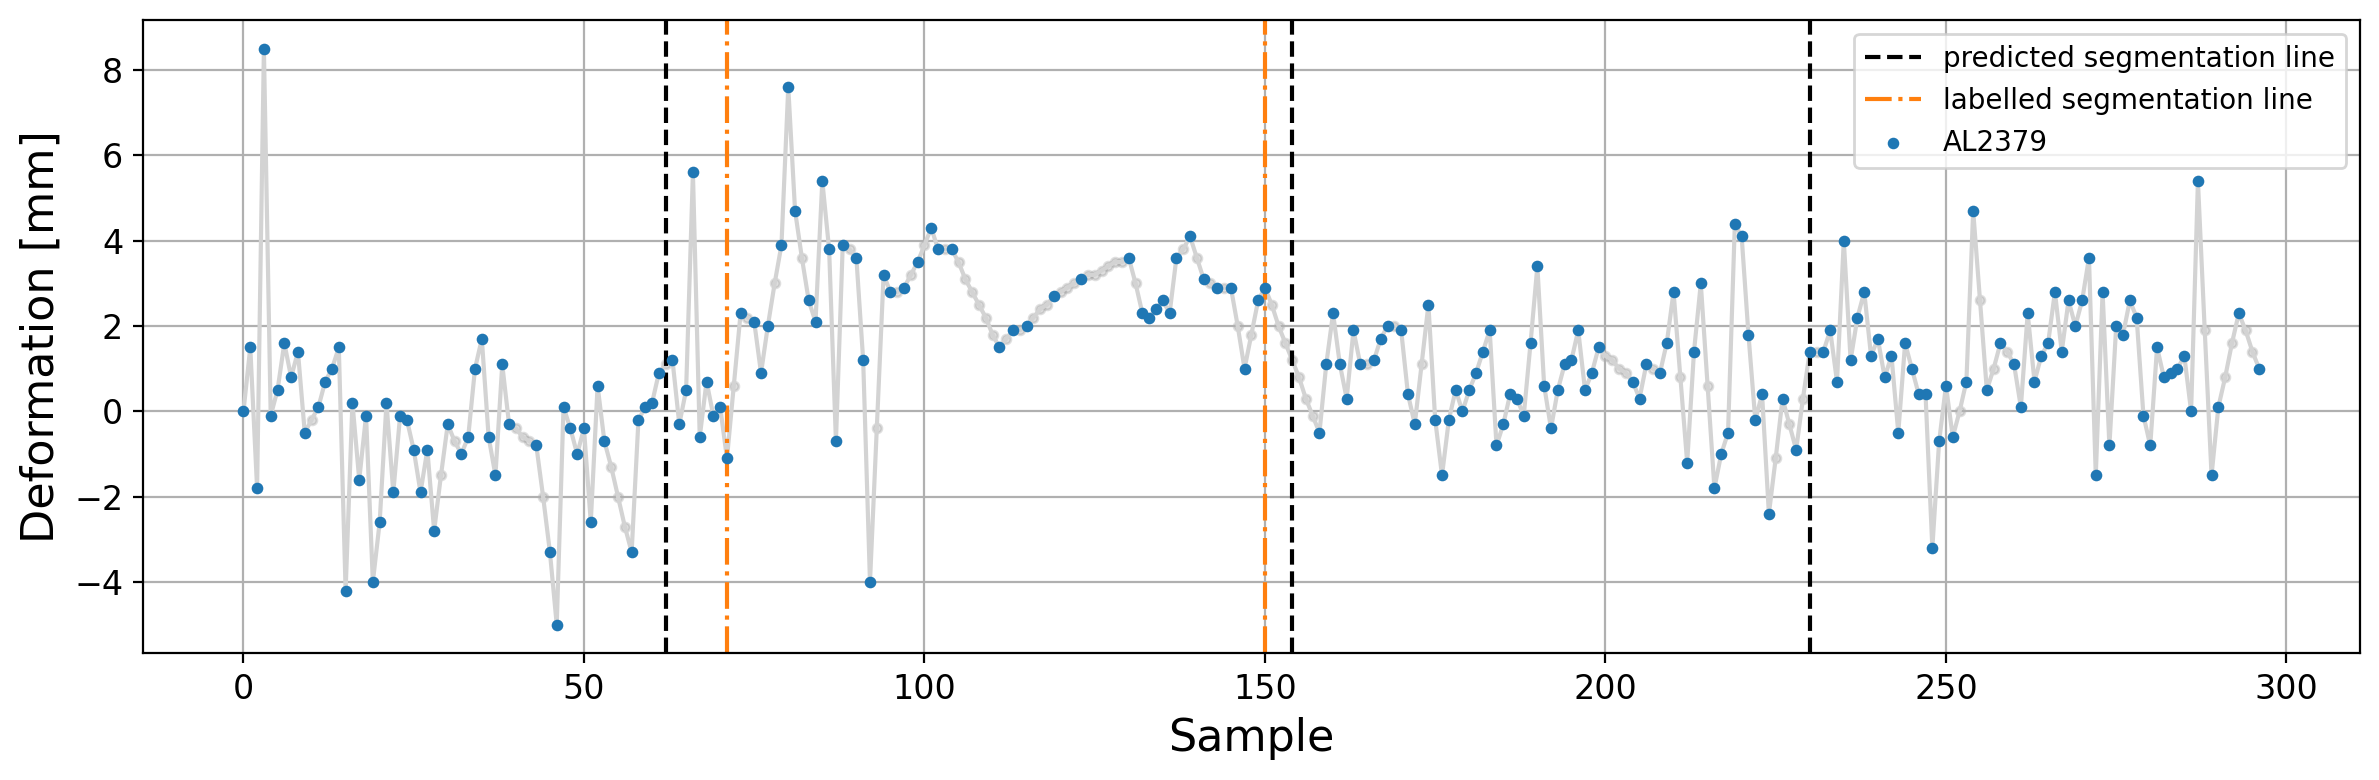

In [155]:
ts = 22

fig = plt.figure(figsize=(12,4), dpi=200)
ax = plt.gca()
plt.plot(X_real[ts], color='lightgrey')
# plt.scatter(range(297), X_real[ts], s=10, zorder=4)
plt.scatter(range(297), X_real[ts], s=10, alpha=0.25, color="tab:grey")
sc = plt.scatter(real_range, X_real[ts][real_range], s=10, zorder=4,  color="tab:blue", label="AL2379")
for i in answers_sup[ts]:
    bv = plt.gca().axvline(i, linestyle='--', color='black', label="predicted segmentation line")
for j in gt[ts]:
    ov = plt.gca().axvline(j, linestyle='-.', color='tab:orange', label="labelled segmentation line")

plt.xlabel("Sample", fontsize = 16)
plt.ylabel("Deformation [mm]", fontsize = 16)
# plt.title("Model F", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[bv, ov, sc])

plt.grid()

fig.tight_layout()
# fig.savefig(f'final_fcnn_model_AL_{ts}.jpg', bbox_inches="tight")

plt.show()